# Tree_Based_Model

## 기본 세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True) # gdrive 수정 가능하게 함

Mounted at /content/drive/


In [2]:
import sys
assert sys.version_info >= (3, 5), "Python version is low!"

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
import pandas as pd

np.random.seed(42)

# Matplotlib 그래프 출력 관련 설정
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

# 그림 저장 설정 -> 이거 나중에 일할 때 많이 씀
PROJECT_ROOT_DIR = "/content/drive/MyDrive/2022년/파이썬 패키지/rosnet/garage" #colab 기반이면 이거 수정하는 게 좋음
ID = "TreeBasedModel" #나중에 파일 정리 다시 하기 싫으면 이거 적어둬야 함
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_name, tight_layout = True, fig_extension = "png", dpi=300):
  path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
  print("[이미지 저장] : ", fig_name)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=dpi)

def save_fig_fig(fig, fig_name, tight_layout = True, fig_extension = "png", dpi=300):
  path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
  print("[이미지 저장] : ", fig_name)
  if tight_layout:
    plt.tight_layout()
  fig.savefig(path, format=fig_extension, dpi=dpi)

# 데이터를 넘파이로 저장을 하네. 그냥 판다스 내장 함수 쓰는게 더 편할 거 같은데
def save_data(fileName, arrayName, header=''):
  np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')

In [3]:
path = PROJECT_ROOT_DIR + "/data/Titanic_all_end.csv"

data_origin = pd.read_csv(path, index_col = 0)
data_origin.head()

,PassengerId,Survived,Pclass,Sex,Fare_q,Age,SibSp,Parch
0,1,0.0,3,0,1,22.0,0,0
1,3,1.0,3,1,3,26.0,0,0
2,5,0.0,3,0,1,35.0,0,0
4,7,0.0,1,0,9,54.0,0,0
5,12,1.0,1,1,7,58.0,0,0


In [4]:
data = data_origin.to_numpy()
data

array([[1.000e+00, 0.000e+00, 3.000e+00, ..., 2.200e+01, 0.000e+00,
        0.000e+00],
       [3.000e+00, 1.000e+00, 3.000e+00, ..., 2.600e+01, 0.000e+00,
        0.000e+00],
       [5.000e+00, 0.000e+00, 3.000e+00, ..., 3.500e+01, 0.000e+00,
        0.000e+00],
       ...,
       [1.234e+03,       nan, 3.000e+00, ..., 3.000e+01, 1.000e+00,
        9.000e+00],
       [1.236e+03,       nan, 3.000e+00, ..., 1.200e+01, 1.000e+00,
        1.000e+00],
       [1.257e+03,       nan, 3.000e+00, ..., 2.900e+01, 1.000e+00,
        9.000e+00]])

In [5]:
x_train = data_origin[~data_origin.Survived.isna()]
y_train = x_train.pop('Survived')
x_train.pop('PassengerId')

x_test = data_origin[data_origin.Survived.isna()]
x_test.pop('Survived')
x_test.pop('PassengerId')

612     892
613     893
614     894
615     895
616     897
       ... 
262    1301
216    1080
242    1234
244    1236
250    1257
Name: PassengerId, Length: 418, dtype: int64

[이미지 저장] :  /반복문 Numpy 속도 비교


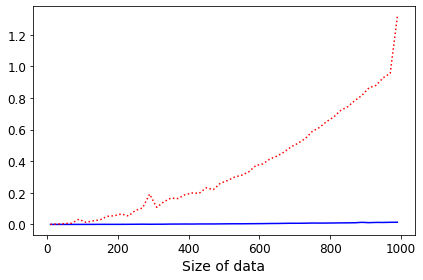

In [10]:
import time
from itertools import product

time1 = []
time2 = []
time3 = []

size = range(10, 1000, 20)

for test in size:
  temp = np.arange(test*test*300).reshape(test, test, 300)

  start = time.time()
  col = (np.transpose(temp, [2,0,1])[0] < 2)
  time1.append(time.time() - start)

  start = time.time()
  temp = np.arange(test*test*300).reshape(test, test, 300)
  temp2 = np.zeros([test, test])
  for i, j in product(range(test), range(test)):
    temp2[i, j] = temp[i, j, 0]
  col = (temp2 < 2)
  time2.append(time.time() - start)


plt.plot(size, time1, 'b-')
plt.plot(size, time2, 'r:')
plt.xlabel("Size of data")
save_fig('/반복문 Numpy 속도 비교')

## Decision Tree

In [ ]:
class Threshold:
  def __init__(self, unit, axis, col, is_continue):
    self.unit_ = unit
    self.axis_ = axis
    self.is_continue_ = is_continue
    self.col_ = col
  
  def get_cost(self, y, condition):
    count_true = []
    count_false = []

    cost_true = 1
    cost_false = 1
    y_true = y[condition]
    y_false = y[~condition]
    
    # 이 부분부터 y가 벡터로 고정이 되어 있다.
    tot_true = y_true.shape[0]
    tot_false = y_false.shape[0]
    tot = tot_true + tot_false

    for uni in np.unique(y):
      cost_true -= np.power((y_true == uni).sum()/tot_true, 2)
      cost_false -= np.power((y_false == uni).sum()/tot_false, 2)

    cost = tot_true/tot * cost_true + tot_false/tot * cost_false
    return cost

  def divide(self, x, y = None):
    column = np.transpose(x, self.axis_)[self.col_]
    if y is not None:
      if self.is_continue_:
        condition = column < self.unit_
        return x[condition], x[~condition], y[condition], y[~condition]

      elif np.isnan(self.unit_):
        condition = np.isnan(column)
        return x[condition], x[~condition], y[condition], y[~condition]
      
      else:
        condition = column == self.unit_
        return x[condition], x[~condition], y[condition], y[~condition]
    
    else:
      if self.is_continue_:
        condition = column < self.unit_
        return x[condition], x[~condition]

      elif np.isnan(self.unit_):
        condition = np.isnan(column)
        return x[condition], x[~condition]
      
      else:
        condition = column == self.unit_
        return x[condition], x[~condition]

class TreeNode:
  def __init__(self, parent = None, left = None, right = None):
    if parent is not None:
      self.is_root = True
    else:
      self.is_root = False

    if left is None:
      self.left_ = left
    if right is None:
      self.right_ = right
    self.step_ = 0.1
    self.continue_limit_ = 4
    self.cost_ = 1
  def add_left(self, left):
    self.left_ = left
  
  def add_right(self, right):
    self.right_ = right
  
  def fit(self, x, y):
    except_col = range(len(y.shape))
    d = 0
    for col_max in x.shape:
      if d in except_col:
        d += 1
        continue
      
      for col in range(col_max):
        axis = list(range(len(x.shape)))
        axis.pop(d)
        axis.insert(0, d)
        column = np.transpose(x, axis)[col]
        unique_ = np.unique(column)

        # unique가 discrete로 취급하는게 편한 경우
        if len(unique_) < self.continue_limit_:
          for uni in unique_:
            new_threshold = Threshold(uni, axis, col, False)
            condition = column == uni
            new_cost = new_threshold.get_cost(y, condition)
            if self.cost_ > new_cost:
              self.cost_ = new_cost
              self.threshold_ = new_threshold

        # unique가 conitnue로 취급하는게 편한 경우
        else:
          for uni in unique_:
            if np.isnan(uni):
              new_threshold = Threshold(uni, axis, col, False)
              condition = np.isnan(column)
              new_cost = new_threshold.get_cost(y, condition)
              if self.cost_ > new_cost:
                self.cost_ = new_cost
                self.threshold_ = new_threshold

          for q in np.arange(self.step_, 1, self.step_):
            uni = np.quantile(column, q)
            new_threshold = Threshold(uni, axis, col, True)
            condition = column < uni
            new_cost = new_threshold.get_cost(y, condition)
            if self.cost_ > new_cost:
              self.cost_ = new_cost
              self.threshold_ = new_threshold

    
      d += 1

  def predict(self, x, y=None):
    if y is None:
      return self.threshold_.divide(x)
    else:
      return self.threshold_.divide(x, y)

  # 나중에 causal discovery용으로 수정할 때 이 부분을 수정해야 한다.
  def get_cost(self, x, y, uni, axis, except_col):
    tot = x.shape[0]
    # 일단 axis랑 uni로 데이터를 짤라 내야 한다.

  def __str__(self):
    return f"[Threshold_axis] : {self.threshold_.axis_[0]} [T_col] : {self.threshold_.col_} [T_unit] : {self.threshold_.unit_:.3f} [cost] : {self.cost_:.3f}"


In [ ]:
x_train_n = x_train.to_numpy()
y_train_n = y_train.to_numpy()

model = TreeNode()
model.fit(x_train_n, y_train_n)
print(model)

[Threshold_axis] : 1 [T_col] : 1 [T_unit] : 0.000 [cost] : 0.333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
x_left, x_right, y_left, y_right = model.predict(x_train_n, y = y_train_n)
(x_left[:, 1] == 0).sum() == len(x_left)

True